In [2]:
import os
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from distance import distance_calculator
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import multiprocessing
from plot_imerg_for_mrms_Individually import imerg_for_mrms_indiv
import geopandas as gpd
import shapely.geometry as geom
from sh import gunzip
import pickle
from multiprocessing import Pool
from shapely.geometry import Point
import warnings
warnings.filterwarnings("ignore") 

In [3]:
data_type = "MRMS"
SHIPS = pd.read_csv('/Users/acheung/data/SHIPS/all_SHIPs_data_combined_north_atlantic.csv')
SHIPS = SHIPS.where(pd.to_datetime(SHIPS['Time']) >= dt.datetime(2015,5,6)).dropna()
near_land_cases = SHIPS.where(SHIPS['DTL'] <50).dropna()


In [4]:
# def min_distance(point, lines):
#     return lines.distance(point).min()
# dist_list = []
# for ships_inds in near_land_cases.index:

#     coastline = gpd.read_file('/Users/acheung/data/Shapefiles/tl_2024_us_coastline.shp')
#     coastline = coastline.where(
#         (coastline['NAME'] == 'Gulf') | (coastline['NAME'] == 'Atlantic')).dropna()
    
#     PR_inds = list([271,277,list(np.arange(281,304)),list(np.arange(920,935))])

#     def flatten(test_list):
#         if isinstance(test_list, list):
#             temp = []
#             for ele in test_list:
#                 temp.extend(flatten(ele))
#             return temp
#         else:
#             return [test_list]

#     flattened_pr = flatten(PR_inds)
    
#     coastline_no_pr = coastline.drop(flattened_pr)

#     # coastline = gpd.clip(gpd.read_file('ne_10m_coastline.shp'), us).to_crs('EPSG:3087')
#     coastline_no_pr = coastline_no_pr.to_crs('EPSG:3087')
#     points_df = gpd.GeoDataFrame({
#         'geometry': [
#             Point(360-SHIPS['LON'].loc[ships_inds], SHIPS['LAT'].loc[ships_inds])]}, crs='EPSG:4326')
#     points_df = points_df.to_crs('EPSG:3087') # https://epsg.io/3087

#     points_df['min_dist_to_coast'] = points_df.geometry.apply(min_distance, args=(coastline_no_pr,))
#     print((points_df['min_dist_to_coast']/1000)[0])
#     dist = (points_df['min_dist_to_coast']/1000)[0]
#     dist_list.append(dist)
# distances_to_us_coast = pd.DataFrame(dist_list,index = near_land_cases.index)
# distances_to_us_coast.to_csv('/Users/acheung/data/intermediates/dists_to_us_coast_50.csv')

In [5]:
distances_to_us_coast = pd.read_csv('/Users/acheung/data/intermediates/dists_to_us_coast_50.csv')['0']
distances_to_us_coast.index = near_land_cases.index

In [6]:
near_us_coast_cases = near_land_cases.loc[distances_to_us_coast.where(distances_to_us_coast < 100).dropna().index]
atcf_ids = near_us_coast_cases['Storm_ID'].unique()


In [7]:
interpolated_mrms_list = []
imerg_precip_list = []
lat_lon_arr_list = []
time_strings_list = []
individual_times_list = []

ground_mrms_total_list = []
# for atcf_it in range(len(atcf_ids)):
for atcf_it in [20]:
    current_near_land_case = near_us_coast_cases.where(near_land_cases['Storm_ID'] == atcf_ids[atcf_it]).dropna()
    current_storm_name = str(current_near_land_case['Name'].unique()[0])
    current_storm_ID = str(current_near_land_case['Storm_ID'].unique()[0])

    desired_lat = current_near_land_case['LAT'].mean()
    desired_lon = 360-current_near_land_case['LON'].mean()

    start_str = current_near_land_case['Time'].iloc[0]
    end_str = str(pd.to_datetime(current_near_land_case['Time'].iloc[-1]) + dt.timedelta(hours=6)) # Add 6 hours after best-track ends!
    time_strings_list.append(start_str + ', end = ' + end_str)
    
    times_pd = pd.date_range(start=start_str,end=end_str, freq='1h')
    times_pd = times_pd[0:-1] + dt.timedelta(hours=1) # We offset the MRMS time by one hour because the timestamp is at the end of one hour time window

    filepaths = []
    problematic_times = []
    for i in times_pd: # Download all the desired IMERG Images
        # If IMERG file does not exist, download it

        year = i.strftime('%Y')
        month = i.strftime('%m')
        day =  i.strftime('%d')
        hour = i.strftime('%H')

        if (times_pd[0]).to_pydatetime() >= dt.datetime(2020,10,15): # Switch to dual-pol led to file directory change! Keep this in mind!
            data_file_path = '/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day+\
                '/MultiSensor_QPE_01H_Pass2_00.00_' + year+month+day+'-'+hour+'0000.grib2'
            url_desired = "https://mtarchive.geol.iastate.edu/"+year+"/"+month+"/"+day+"/mrms/ncep/MultiSensor_QPE_01H_Pass2/"\
                + 'MultiSensor_QPE_01H_Pass2_00.00_' + year+month+day+'-'+hour+'0000.grib2.gz'

        elif (times_pd[0]).to_pydatetime() < dt.datetime(2020,10,15): # Switch to dual-pol led to file directory change! Keep this in mind!
            data_file_path = '/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day+\
                '/GaugeCorr_QPE_01H_00.00_' + year+month+day+'-'+hour+'0000.grib2'
            url_desired = "https://mtarchive.geol.iastate.edu/"+year+"/"+month+"/"+day+"/mrms/ncep/GaugeCorr_QPE_01H/"\
                + 'GaugeCorr_QPE_01H_00.00_' + year+month+day+'-'+hour+'0000.grib2.gz'

    # If day directory does not exist, make day directory
        if os.path.exists('/Users/acheung/data/MRMS/'+year) == False:
            os.mkdir('/Users/acheung/data/MRMS/'+year)

        if os.path.exists('/Users/acheung/data/MRMS/'+year+'/'+month) == False:
            os.mkdir('/Users/acheung/data/MRMS/'+year+'/'+month)

        if os.path.exists('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day) == False:
            os.mkdir('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day)

        if os.path.exists(data_file_path) == False:

            os.chdir('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day)
            try:
                os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                          + url_desired)
                # wget.download(url_desired)
                gunzip(data_file_path+'.gz')
                # os.system('gzip -d '+data_file_path+'.gz')
            except:
                problematic_times.append(i)
                print('Skipped MRMS time ' + str(i))
                continue
        filepaths.append(data_file_path)
        problematic_times_arr = np.asarray(problematic_times) # More or less, remove any times from imerg that mrms did not have
    # ---------------------------------------------------------------------------------------------------------


    # Use multiprocessing to slice MRMS or Stage IV Data (speeds up process significantly)

    def slicing_file(case_loop,filepaths,desired_lon,desired_lat):
        import numpy as np
        import xarray as xr
        import sys
        sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
        from distance import distance_calculator

        ground_based_data = xr.open_dataset(filepaths[case_loop], engine="cfgrib")['unknown']
        x, y = np.float32(np.meshgrid(ground_based_data['longitude'], ground_based_data['latitude']))


        # Find index closest to interpolated best-track center or 2-km radar center
        distance_arr = distance_calculator(x,y,(desired_lon,desired_lat))

        abs_dist_arr = (abs(distance_arr))

        min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))

        # Slice arrays to within 400 indices of desired center

        sliced_lon_grid = x[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

        sliced_lat_grid = y[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

        sliced_ground_based_data = ground_based_data[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

        sliced_ground_based_data_masked = sliced_ground_based_data.where(sliced_ground_based_data.values >=0)
        return np.asarray([sliced_ground_based_data_masked,sliced_lon_grid,sliced_lat_grid])
    #-------------------------------------------------------------------------------------------------------

    # this helper function is needed because map() can only be used for functions
    # that take a single argument (see http://stackoverflow.com/q/5442910/1461210)
    def splat_slicing(args):
        return slicing_file(*args)

    pool = Pool(32)
    iteration_length = len(filepaths)

    def parallel_slicing(iteration_length):
        result_slicing = pool.map(splat_slicing, ((iteration,filepaths,desired_lon,desired_lat
                                                  ) for iteration in range(iteration_length)))
        # return np.asarray(result_slicing), result_slicing[0]['latitude'],result_slicing[0]['longitude']
        return result_slicing

    # ground_total_precip,sliced_lat_1d,sliced_lon_1d= parallel_slicing(iteration_length)
    result_slicing= parallel_slicing(iteration_length)
    mrms_array = np.asarray(result_slicing)
    ground_total_precip = mrms_array[:,0]
    mrms_y_grid = mrms_array[0,2]
    mrms_x_grid = mrms_array[0,1]
    mrms_x_grid = mrms_x_grid - 360
    
    ground_mrms_total_list.append([ground_total_precip,mrms_x_grid,mrms_y_grid,times_pd])
    
#     #-------------------------------------------------------------------------------------------------------
    
#     # Sum up precipitation (MRMS data is hourly QPE)
#     summed_precip_post = np.sum(ground_total_precip,axis=0)

#      #------------------------Process IMERG data based on MRMS Used-------------------------------------------

    imerg_for_mrms_indiv(start_str,end_str,desired_lon,desired_lat,problematic_times_arr)
    imerg_precip_data_pre = xr.open_dataset('/Users/acheung/data/intermediates/imerg_individual/start = '+start_str+', end = '+end_str+' imerg.nc')['__xarray_dataarray_variable__']

    summed_1h_imerg_xr = xr.DataArray(
        data=((imerg_precip_data_pre[0::2].values + imerg_precip_data_pre[1::2].values) * 0.5),
        dims=["time","lon", "lat"],coords=imerg_precip_data_pre[0::2].coords,
        attrs=dict(
            description="IMERG Precip Rate",
            units="mm")) # NOTE THAT THIS IS IMERG TIME, NOT MRMS TIME! Represents the BEGINNING of 1 h time period

    # imerg_precip_data = xr.open_dataset('/Users/acheung/data/intermediates/start = '+start_str+', end = '+end_str+' imerg.nc')['__xarray_dataarray_variable__']
    
    #-------------------------------------Begin Barnes Analysis----------------------------------
    def Barnes_Point_Value(ind_zero_loop, ind_one_loop,imerg_precip_data, current_ground_total_precip,mrms_x_grid,mrms_y_grid,dataset_smoothed):
        # Perform your desired operation
    
        if dataset_smoothed == 'MRMS':
            euclidian_dist = np.sqrt(((imerg_precip_data['lat'].values[ind_zero_loop][ind_one_loop] - mrms_y_grid)**2) +
                                 ((imerg_precip_data['lon'].values[ind_zero_loop][ind_one_loop] - mrms_x_grid)**2))
        elif dataset_smoothed == 'IMERG':
            euclidian_dist = np.sqrt(((imerg_precip_data['lat'].values[ind_zero_loop][ind_one_loop] - imerg_precip_data['lat'].values)**2) +
                         ((imerg_precip_data['lon'].values[ind_zero_loop][ind_one_loop] - imerg_precip_data['lon'].values)**2))

        interested_euclid = pd.DataFrame(euclidian_dist).where(euclidian_dist < 1)
        c = 0.05 # std setting

        weight_func = np.exp(-(interested_euclid**2)/(2*(c**2)))
        norm_weight_func = weight_func/(weight_func.sum().sum())

        if dataset_smoothed == 'MRMS':
            this_point_value = np.nansum(norm_weight_func * current_ground_total_precip)
        elif dataset_smoothed == 'IMERG':
            this_point_value = np.nansum(norm_weight_func * imerg_precip_data.values)

        return this_point_value

#----------------------------Multiprocessing for Barnes Analysis---------------------------------------------


    # this helper function is needed because map() can only be used for functions
    # that take a single argument (see http://stackoverflow.com/q/5442910/1461210)
    def splat_barnes(args):
        return Barnes_Point_Value(*args)

    pool = Pool(48)

    # a pool of 8 worker processes
    def parallel_barnes(M_barnes, N_barnes,imerg_or_mrms,imerg_precip_data,current_ground_total_precip):
        result_barnes_imerg = pool.map(splat_barnes, ((ind_zero_loop, ind_one_loop,imerg_precip_data, 
                                          current_ground_total_precip,mrms_x_grid,mrms_y_grid,imerg_or_mrms) 
                                         for ind_zero_loop in range(M_barnes) for ind_one_loop in range(N_barnes)))

        return np.array(np.asarray(result_barnes_imerg)).reshape(M_barnes, N_barnes)
    
    imerg_barnes_list = []
    mrms_barnes_list = []
    print('Starting Barnes for Storm ' + str(atcf_it + 1))

    for imerg_time_loop_ind in range(len(summed_1h_imerg_xr)):
        imerg_precip_data = summed_1h_imerg_xr[imerg_time_loop_ind]
        current_ground_total_precip = ground_total_precip[imerg_time_loop_ind]
        M_barnes = imerg_precip_data['lat'].values.shape[0]
        N_barnes = imerg_precip_data['lat'].values.shape[1]
        full_barnes_imerg = parallel_barnes(M_barnes, N_barnes,'IMERG',imerg_precip_data,current_ground_total_precip)
        full_imerg_barnes_arr = np.asarray(full_barnes_imerg)

        full_barnes_mrms = parallel_barnes(M_barnes, N_barnes,'MRMS',imerg_precip_data,current_ground_total_precip)
        full_mrms_barnes_arr = np.asarray(full_barnes_mrms)
#---------------------------Mask Data off coastline------------------------------------------
    
        # Mask Ocean from MRMS and IMERG
        # prepare temporary plot and create mask from rasterized map
        proj = {'projection': cartopy.crs.PlateCarree()}
        fig, ax = plt.subplots(figsize=(imerg_precip_data.shape[0]/100, imerg_precip_data.shape[1]/100), dpi=100, subplot_kw=proj)
        fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)
        ax.set_frame_on(False)

        ax.add_feature(cartopy.feature.OCEAN, facecolor='black')


        ax.set_extent((float(imerg_precip_data['lon'].min()),float(imerg_precip_data['lon'].max()),
                       float(imerg_precip_data['lat'].min()),float(imerg_precip_data['lat'].max())))
        fig.canvas.draw()
        mask = fig.canvas.tostring_rgb()
        ncols, nrows = fig.canvas.get_width_height()
        plt.close(fig)

        mask = np.frombuffer(mask, dtype=np.uint8).reshape(nrows, ncols, 3)
        mask = mask.mean(axis=2)
        mask = np.rot90(np.fliplr(mask),k=2)
        masked_mrms  = np.where(mask>0, full_mrms_barnes_arr, np.nan)
        masked_imerg  = np.where(mask>0, full_barnes_imerg, np.nan)
        # imerg_precip_list.append(masked_imerg)
        # interpolated_mrms_list.append(masked_mrms)

        mrms_barnes_list.append(masked_mrms)
        imerg_barnes_list.append(masked_imerg)

        print(str(imerg_time_loop_ind + 1) + ' of ' + str(len(summed_1h_imerg_xr)) + ' Barnes Completed')

#     #-------------------------------------End Barnes Analysis----------------------------------
    interpolated_mrms_list.append(mrms_barnes_list)
    imerg_precip_list.append(imerg_barnes_list)
    lat_lon_arr_list.append([imerg_precip_data_pre['lat'].values, imerg_precip_data_pre['lon'].values])
    individual_times_list.append(summed_1h_imerg_xr['time'].values) # Time is the beginning of the 1 h window
    print(str(atcf_it + 1) + ' of '+ str(len(atcf_ids)) + ' Storms')

Starting Barnes for Storm 21
1 of 18 Barnes Completed
2 of 18 Barnes Completed
3 of 18 Barnes Completed
4 of 18 Barnes Completed
5 of 18 Barnes Completed
6 of 18 Barnes Completed
7 of 18 Barnes Completed
8 of 18 Barnes Completed
9 of 18 Barnes Completed
10 of 18 Barnes Completed
11 of 18 Barnes Completed
12 of 18 Barnes Completed
13 of 18 Barnes Completed
14 of 18 Barnes Completed
15 of 18 Barnes Completed
16 of 18 Barnes Completed
17 of 18 Barnes Completed
18 of 18 Barnes Completed
21 of 42 Storms


In [156]:
# with open('/Users/acheung/data/intermediates/mrms_list_indiv.pkl', 'wb') as f:
#     pickle.dump(interpolated_mrms_list, f)
    
# with open('/Users/acheung/data/intermediates/lat_lon_list_indiv.pkl', 'wb') as f:
#     pickle.dump(lat_lon_arr_list, f)
    
# with open('/Users/acheung/data/intermediates/imerg_list_indiv.pkl', 'wb') as f:
#     pickle.dump(imerg_precip_list, f)
    
# with open('/Users/acheung/data/intermediates/time_strings_list_indiv.pkl', 'wb') as f:
#     pickle.dump(time_strings_list, f)
    
# # with open('/Users/acheung/data/intermediates/ground_mrms_total_list.pkl', 'wb') as f:
# #     pickle.dump(ground_mrms_total_list, f)

In [4]:
with open('/Users/acheung/data/intermediates/mrms_list_indiv.pkl', 'rb') as file:
    # Load the data from the file
    interpolated_mrms_list = pickle.load(file)
    
with open('/Users/acheung/data/intermediates/lat_lon_list_indiv.pkl', 'rb') as file:
    # Load the data from the file
    lat_lon_arr_list = pickle.load(file)
    
with open('/Users/acheung/data/intermediates/imerg_list_indiv.pkl', 'rb') as file:
    # Load the data from the file
    imerg_precip_list = pickle.load(file)
    
with open('/Users/acheung/data/intermediates/time_strings_list_indiv.pkl', 'rb') as file:
    # Load the data from the file
    time_strings_list = pickle.load(file)
    
with open(    '/Users/acheung/data/intermediates/datetimes_indiv.pkl', 'rb') as file:
    # Load the data from the file
    individual_times_list = pickle.load(file)
# with open('/Users/acheung/data/intermediates/ground_mrms_total_list.pkl', 'rb') as file:
#     # Load the data from the file
#     ground_mrms_total_list = pickle.load(file)

Text(0.5, 1.0, 'IMERG Post-Barnes Analysis')

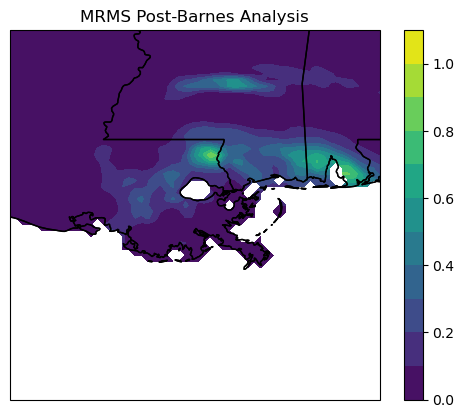

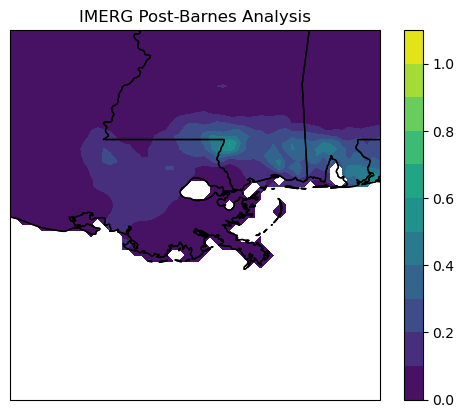

In [26]:
ind_to_see = 5
storm_ind = 20

fig1 = plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
plot_1 = ax.contourf(lat_lon_arr_list[storm_ind][1],lat_lon_arr_list[storm_ind][0],
                     interpolated_mrms_list[storm_ind][ind_to_see]/25.4,
                    levels=np.arange(0,1.2,0.1))
plt.colorbar(plot_1)
ax.set_title('MRMS Post-Barnes Analysis')

fig2 = plt.figure()
ax2=plt.axes(projection=ccrs.PlateCarree())
ax2.add_feature(cfeature.STATES)
ax2.add_feature(cfeature.COASTLINE)
plot_2 = ax2.contourf(lat_lon_arr_list[storm_ind][1],lat_lon_arr_list[storm_ind][0],
                      imerg_precip_list[storm_ind][ind_to_see]/25.4,
                    levels=np.arange(0,1.2,0.1))
plt.colorbar(plot_2)
ax2.set_title('IMERG Post-Barnes Analysis')

Text(0.5, 1.0, 'IMERG Before Barnes')

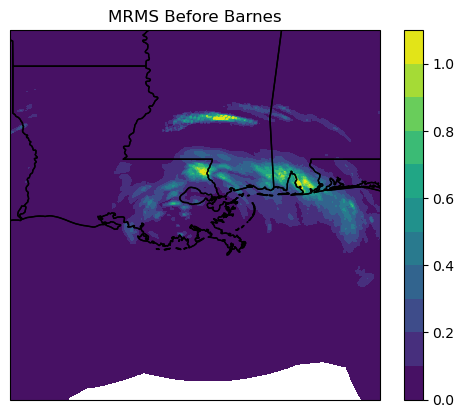

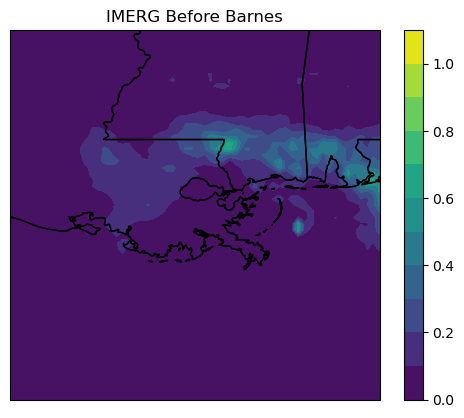

In [34]:
fig4 = plt.figure()
ax4=plt.axes(projection=ccrs.PlateCarree())
ax4.add_feature(cfeature.STATES)
ax4.add_feature(cfeature.COASTLINE)
p4 = ax4.contourf(mrms_x_grid,mrms_y_grid,ground_total_precip[ind_to_see]/25.4,
                 levels=np.arange(0,1.2,0.1))
ax4.set_title('MRMS Before Barnes')
plt.colorbar(p4)

fig3 = plt.figure()
ax3=plt.axes(projection=ccrs.PlateCarree())
ax3.add_feature(cfeature.STATES)
ax3.add_feature(cfeature.COASTLINE)
p3 = ax3.contourf(imerg_precip_data_pre['lon'].values,imerg_precip_data_pre['lat'].values,summed_1h_imerg_xr[ind_to_see]/25.4,
                 levels=np.arange(0,1.2,0.1))
plt.colorbar(p3)
ax3.set_title('IMERG Before Barnes')


In [6]:
# # this is for plotting all images before Barnes

# ground_data = []
# x_data = []
# y_data = []
# time_data = []
# for l in range(len(ground_mrms_total_list)):
#     ground_data.append(ground_mrms_total_list[l][0])
    
# for xl in range(len(ground_mrms_total_list)):
#     x_data.append(ground_mrms_total_list[xl][1])
    
# for yl in range(len(ground_mrms_total_list)):
#     y_data.append(ground_mrms_total_list[yl][2])
    
# for tl in range(len(ground_mrms_total_list)):
#     time_data.append(ground_mrms_total_list[tl][3])


In [7]:
# import multiprocessing

# def plotting_mrms(ground_data,x_data,y_data,plot_first):
#     current_storm_data = ground_data[plot_first]
#     current_storm_x = x_data[plot_first]
#     current_storm_y = y_data[plot_first]
#     current_storm_time = time_data[plot_first]
#     for plot_i in range(len(ground_data[plot_first])):
#         fig1 = plt.figure()
#         ax=plt.axes(projection=ccrs.PlateCarree())
#         ax.add_feature(cfeature.STATES)
#         ax.add_feature(cfeature.COASTLINE)
#         nowplot=ax.contourf(current_storm_x,current_storm_y,current_storm_data[plot_i]/25.4,levels=np.arange(0,1.5,0.1))
#         plt.colorbar(nowplot,label='1h rainfall (in)')
#         ax.set_title('MRMS' + str(current_storm_time[plot_i]))
#         plt.savefig('/Users/acheung/data/Figures/Individual_MRMS/MRMS_' + str(current_storm_time[plot_i]) + '.png')
#         plt.close()

# ground_length = len(ground_data)

# if __name__ == '__main__':
#     with multiprocessing.Manager() as manager:
#         shared_list = manager.list()

#         processes = []
#         for plot_first in range(ground_length):
#             p = multiprocessing.Process(target=plotting_mrms, args=(ground_data,x_data,y_data,plot_first))
#             processes.append(p)
#             p.start()

#         for p in processes:
#             p.join()

In [36]:
def splat_plotting(args):
    return plotting_mrms(*args)

pool = Pool(4)
ground_length = len(ground_data)

def parallel_plotting(ground_length):
     pool.map(splat_plotting, ((ground_data,x_data,y_data,plot_first
                                               ) for plot_first in range(ground_length)))
    
def plotting_mrms(ground_data,x_data,y_data,plot_first):
    current_storm_data = ground_data[plot_first]
    current_storm_x = x_data[plot_first]
    current_storm_y = y_data[plot_first]
    current_storm_time = time_data[plot_first]
    for plot_i in range(len(ground_data[plot_first])):
        fig1 = plt.figure()
        ax=plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.STATES)
        ax.add_feature(cfeature.COASTLINE)
        nowplot=ax.contourf(current_storm_x,current_storm_y,current_storm_data[plot_i]/25.4,levels=np.arange(0,1.5,0.1))
        plt.colorbar(nowplot,label='1h rainfall (in)')
        ax.set_title('MRMS' + str(current_storm_time[plot_i]))
        plt.savefig('/Users/acheung/data/Figures/Individual_MRMS/MRMS_' + str(current_storm_time[plot_i]) + '.png')
        plt.close()
        
parallel_plotting(ground_length)   

NameError: name 'ground_data' is not defined

In [5]:
def fraction_calculator(lat_lon_now,masked_imerg,masked_mrms,imerg_ind_0,imerg_ind_1,radius_to_include,thresholds):
    import sys
    sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
    from distance import distance_calculator
    import numpy as np
    import warnings
    import xarray as xr
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    # If the thresholds calculate from the same dataset (e.g., IMERG), it means that we are including bias
    imerg_threshold = np.nanpercentile(masked_imerg,thresholds[0])
    mrms_threshold = np.nanpercentile(masked_imerg,thresholds[-1])

    distance_arr_imerg = distance_calculator(lat_lon_now[1],lat_lon_now[0],
                                       (lat_lon_now[1][imerg_ind_0,imerg_ind_1],
                                        lat_lon_now[0][imerg_ind_0,imerg_ind_1]))

    masked_imerg_xr = xr.DataArray(masked_imerg)
    inside_rad_imerg = (masked_imerg_xr.where(distance_arr_imerg < radius_to_include)).values.ravel()
    inside_rad_imerg_no_nan = inside_rad_imerg[~np.isnan(inside_rad_imerg)]
    fraction_rad_imerg = (inside_rad_imerg_no_nan > imerg_threshold).sum()/len(inside_rad_imerg_no_nan)
    
    distance_arr_mrms = distance_calculator(lat_lon_now[1],lat_lon_now[0],
                                       (lat_lon_now[1][imerg_ind_0,imerg_ind_1],
                                        lat_lon_now[0][imerg_ind_0,imerg_ind_1]))
    
    masked_mrms_xr = xr.DataArray(masked_mrms)
    inside_rad_mrms = (masked_mrms_xr.where(distance_arr_mrms < radius_to_include)).values.ravel()
    inside_rad_mrms_no_nan = inside_rad_mrms[~np.isnan(inside_rad_mrms)]
    fraction_rad_mrms = (inside_rad_mrms_no_nan > mrms_threshold).sum()/len(inside_rad_mrms_no_nan)
    return np.asarray([fraction_rad_imerg,fraction_rad_mrms])


In [77]:
from multiprocessing import Pool

# Stack overflow: https://stackoverflow.com/questions/29857498/how-to-apply-a-function-to-a-2d-numpy-array-with-multiprocessing

def splat_f(args):
    return fraction_calculator(*args)

# a pool of 78 worker processes
pool = Pool(86)
M = imerg_precip_list[0][0].shape[0] # Using [0][0] is okay since all images are the same shape
N = imerg_precip_list[0][0].shape[1]

def parallel(fraction_now_ind,indiv_image_loop,M, N,radius_to_include,thresholds):
    lat_lon_now = lat_lon_arr_list[fraction_now_ind]
    masked_imerg = imerg_precip_list[fraction_now_ind][indiv_image_loop]              
    masked_mrms = interpolated_mrms_list[fraction_now_ind][indiv_image_loop]

    result = pool.map(splat_f, ((lat_lon_now,masked_imerg,masked_mrms,
                                  imerg_ind_0,imerg_ind_1,radius_to_include,thresholds) for imerg_ind_0 in range(M) for imerg_ind_1 in range(N)))

    return np.array(np.asarray(result)[:,0]).reshape(M, N),np.array(np.asarray(result)[:,1]).reshape(M, N)


In [81]:
import time
start_time = time.time()

# Your code here
thresholds = [thresholds_wanted[0]]
imerg_fractions,mrms_fractions = parallel(0,0,M,N,50,thresholds)

end_time = time.time()

execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 0.31125354766845703 seconds


In [11]:
test_radii = np.concatenate([np.arange(10,60,5),np.arange(60,800.1,50)])
thresholds_wanted = [75,90,95,99]


In [28]:
# Calculate fractions in parallel

FSS_lists_with_all_thresholds = [] # appends once per threshold
for thresholds_interested in thresholds_wanted:
    thresholds = [thresholds_interested]
    FSS_overall_list = [] # appends once per storm
    for fraction_now_ind in range(len(imerg_precip_list)): # This loops over all storms
        FSS_per_image_list = [] # appends once per image
        for indiv_image_loop in range(len(imerg_precip_list[fraction_now_ind])): # This loops over all images in a storm
            FSS_list = [] # appends once per radius check
            start_time = time.time()
            for radius_loop in test_radii:
                imerg_fractions,mrms_fractions = parallel(fraction_now_ind,indiv_image_loop,M,N,radius_loop,thresholds)
                FBS = (np.nansum((mrms_fractions - imerg_fractions)**2))/len(imerg_fractions.ravel())
                FBS_worst = (np.nansum(mrms_fractions**2) + np.nansum(imerg_fractions**2))/len(imerg_fractions.ravel())
                FSS = 1 - (FBS/FBS_worst)
                FSS_list.append(FSS) # This saves all FSS value to one list, regardless of ROI
            FSS_per_image_list.append(FSS_list)
            end_time = time.time()
            execution_time = end_time - start_time
            print(((thresholds_interested),(fraction_now_ind,len(imerg_precip_list)),(indiv_image_loop,len(imerg_precip_list[fraction_now_ind]))))
            print(f"Execution time: {execution_time} seconds")
        FSS_overall_list.append(FSS_per_image_list)
        print(str(fraction_now_ind + 1) + ' of ' + str(len(imerg_precip_list)) + '; Current Threshold: ' + str(thresholds_interested))
    FSS_lists_with_all_thresholds.append(FSS_overall_list)

with open('/Users/acheung/data/intermediates/FSS_list_indiv.pkl', 'wb') as f:
    pickle.dump(FSS_lists_with_all_thresholds, f)

(75, (0, 42), (0, 42))
Execution time: 5.426708936691284 seconds
(75, (0, 42), (1, 42))
Execution time: 4.718121528625488 seconds
(75, (0, 42), (2, 42))
Execution time: 5.027285099029541 seconds
(75, (0, 42), (3, 42))
Execution time: 4.974740505218506 seconds
(75, (0, 42), (4, 42))
Execution time: 4.6395745277404785 seconds
(75, (0, 42), (5, 42))
Execution time: 5.647051811218262 seconds
(75, (0, 42), (6, 42))
Execution time: 5.514282941818237 seconds
(75, (0, 42), (7, 42))
Execution time: 7.477558135986328 seconds
(75, (0, 42), (8, 42))
Execution time: 7.3137733936309814 seconds
(75, (0, 42), (9, 42))
Execution time: 4.806206703186035 seconds
(75, (0, 42), (10, 42))
Execution time: 4.5383946895599365 seconds
(75, (0, 42), (11, 42))
Execution time: 3.979623556137085 seconds
(75, (0, 42), (12, 42))
Execution time: 6.922648191452026 seconds
(75, (0, 42), (13, 42))
Execution time: 7.239525318145752 seconds
(75, (0, 42), (14, 42))
Execution time: 5.878007173538208 seconds
(75, (0, 42), (15

Traceback (most recent call last):
Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
  File "/homes/metogra/a98alvin/miniconda3/envs/fasterenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_162638/130814049.py", line 13, in <module>
    imerg_fractions,mrms_fractions = parallel(fraction_now_ind,indiv_image_loop,M,N,radius_loop,thresholds)
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_162638/139115757.py", line 18, in parallel
    result = pool.map(splat_f, ((lat_lon_now,masked_imerg,masked_mrms,
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes/metogra/a98alvin/miniconda3/envs/fasterenv/lib/python3.12/multiproc

In [272]:
with open('/Users/acheung/data/intermediates/FSS_list.pkl', 'rb') as file:
    # Load the data from the file
    FSS_lists_with_all_thresholds = pickle.load(file)


(0.0, 350.0)

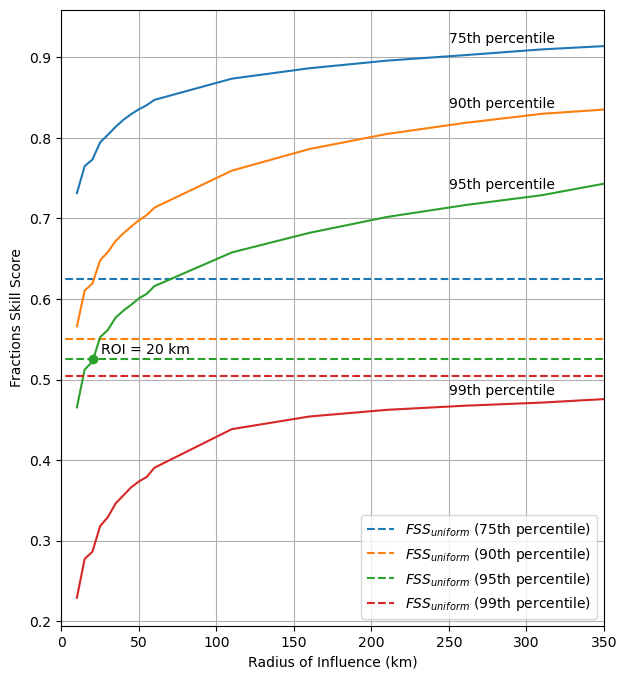

In [312]:
plt.figure(figsize=(7,8))
ax = plt.axes()
ax.grid()
from scipy.interpolate import UnivariateSpline
small_res = np.arange(test_radii.min(),test_radii.max()+0.1,0.1)

for current_FSS_overall_list_ind in range(len(FSS_lists_with_all_thresholds)):
    spl = UnivariateSpline(test_radii, np.asarray(FSS_lists_with_all_thresholds[current_FSS_overall_list_ind]).mean(axis=0),
                      s=0,k=1)
    curve = ax.plot(test_radii,np.asarray(FSS_lists_with_all_thresholds[current_FSS_overall_list_ind]).mean(axis=0))

    
    f0 = 1 - thresholds_wanted[current_FSS_overall_list_ind]/100
    f0_uniform = 0.5+(f0/2)
    h_plot = ax.hlines(f0_uniform,xmin=-100,xmax=test_radii.max()+100,color=curve[0].get_color(),
                       linestyle='dashed',label='$FSS_{uniform}$ (' + str(thresholds_wanted[current_FSS_overall_list_ind])+'th percentile)')

    ax.set_ylabel('Fractions Skill Score')
    ax.set_xlabel('Radius of Influence (km)')
    ax.annotate(str(thresholds_wanted[current_FSS_overall_list_ind])+'th percentile',(250,spl(300)+0.01))
    if sum(np.unique(f0_uniform - spl(small_res)) < 0) > 0: # Only finds crossing point if line exceeds respective FSS uniform
        min_index_for_line = np.argmin(abs(f0_uniform - spl(small_res)))
        x_cross = small_res[min_index_for_line]
        y_cross = spl(small_res)[min_index_for_line]
        if x_cross > test_radii.min() + 0.5:
            plt.scatter(x_cross,y_cross,color=curve[0].get_color())
            ax.annotate('ROI = ' + str(round(x_cross)) +' km',(x_cross+5,y_cross + 0.007))

plt.legend()
ax.set_xlim(0,350)
# ax.set_xscale('log')





In [286]:
test_radii.min()


10.0

In [281]:
f0_uniform - spl(small_res)

array([0.27584071, 0.27487873, 0.27391675, ..., 0.0288515 , 0.02885135,
       0.02885121])

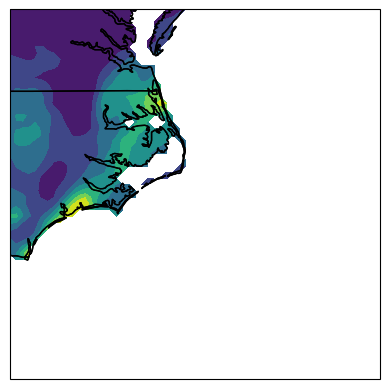

In [14]:
fig7 = plt.figure()
ax7=plt.axes(projection=ccrs.PlateCarree())
ax7.add_feature(cfeature.STATES)
ax7.add_feature(cfeature.COASTLINE)
ax7.contourf(lat_lon_xr[20][1],lat_lon_xr[20][0],mrms_xr[20])

In [54]:
for desired_test_ind in range(len(mrms_xr)):
    fig = plt.figure(figsize=(20, 7)) 

    gs = fig.add_gridspec(1,3)
    ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1,projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1,projection=ccrs.PlateCarree())
    ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1,projection=ccrs.PlateCarree())

    current_time_period = time_strings_list[desired_test_ind]

    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.COASTLINE)

    if np.ceil((mrms_xr[desired_test_ind]).max()) < 10:
        map_interval = 0.5
    elif (np.ceil((mrms_xr[desired_test_ind]).max()) >= 10) and  (np.ceil((mrms_xr[desired_test_ind]).max()) < 20):
        map_interval = 1
    elif (np.ceil((mrms_xr[desired_test_ind]).max()) >= 20) and  (np.ceil((mrms_xr[desired_test_ind]).max()) < 30):
        map_interval = 2    
    elif np.ceil((mrms_xr[desired_test_ind]).max()) >= 30:
        map_interval = 4    


    plot_a = ax.contourf(lat_lon_arr_list[desired_test_ind][1],
                         lat_lon_arr_list[desired_test_ind][0],
                         imerg_xr[desired_test_ind],
                          levels=np.arange(0,np.ceil((mrms_xr[desired_test_ind]).max()),map_interval))

    ax.set_title('IMERG \n' + current_time_period)
    plot_b = ax2.contourf(lat_lon_arr_list[desired_test_ind][1],
                         lat_lon_arr_list[desired_test_ind][0],
                         mrms_xr[desired_test_ind],
                         levels=np.arange(0,np.ceil((mrms_xr[desired_test_ind]).max()),map_interval))

    ax2.add_feature(cfeature.STATES)
    ax2.add_feature(cfeature.COASTLINE)
    ax2.set_title('MRMS \n' + current_time_period)


    ax3.add_feature(cfeature.STATES)
    ax3.add_feature(cfeature.COASTLINE)
    plot_c = ax3.contourf(lat_lon_arr_list[desired_test_ind][1],lat_lon_arr_list[desired_test_ind][0],
                           imerg_xr[desired_test_ind]-mrms_xr[desired_test_ind],cmap='bwr',levels=np.arange(-int(np.ceil(abs(
                                 (imerg_xr[desired_test_ind])-(
                                     mrms_xr[desired_test_ind])).max())),int(np.ceil(
                                 abs(imerg_xr[desired_test_ind]-(
                                     mrms_xr[desired_test_ind])).max()))+0.1,1))
    ax3.set_title('IMERG–MRMS')

    cax_1 = plt.axes([0.105, 0, 0.52, 0.07])
    cax_2 = plt.axes([0.67, 0, 0.23, 0.07])
    # MAKE SURE COLOR LEVELS OF ALL PLOTS ARE SET EQUALLY!!!
    plt.colorbar(plot_b,cax=cax_1,label='Precipitation (in)',orientation='horizontal')
    plt.colorbar(plot_c,cax=cax_2,label='IMERG – MRMS Difference (in)',orientation='horizontal')
    
    plt.savefig('/Users/acheung/data/Figures/mrms_imerg_comparisons/' + current_time_period+'.jpg',bbox_inches='tight')
    plt.close()

In [163]:
def bootstrap(data, R):
 
    means = []
    n = len(data)
 
    for i in range(R):
        sampled_data = data.sample(n=n, replace=True)
        mean = np.nanmean(sampled_data)
        means.append(mean)
 
    return pd.DataFrame(means, columns=['means'])

def confidence_intervals(data, confidence_level=0.95): 
    
    low_end = (1 - confidence_level) / 2
    high_end = 1 - low_end
    bottom_percentile = np.round(data.means.quantile(low_end), 2)
    top_percentile = np.round(data.means.quantile(high_end), 2)
 
    print('The {}% confidence interval is [{}, {}]'.format(
        confidence_level * 100, bottom_percentile, top_percentile))
    return [confidence_level * 100, bottom_percentile, top_percentile,['The {}% confidence interval is {} in to {} in'.format(
        confidence_level * 100, bottom_percentile, top_percentile)]]

In [65]:
diff_xarray = imerg_xr - mrms_xr

diff_pd_flat = abs(pd.DataFrame(diff_xarray.values.ravel()))
bootstrap_means = bootstrap(diff_pd_flat, R=1000)

The 60.0% confidence interval is [0.7, 0.71]
The 70.0% confidence interval is [0.7, 0.71]
The 80.0% confidence interval is [0.7, 0.71]
The 90.0% confidence interval is [0.7, 0.71]
The 95.0% confidence interval is [0.7, 0.71]
The 99.0% confidence interval is [0.69, 0.72]


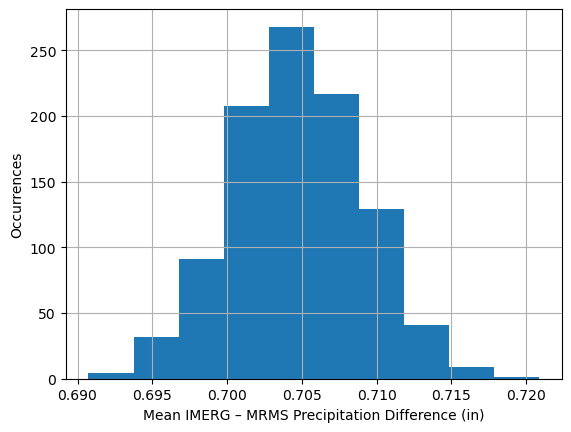

In [115]:
plt.hist(bootstrap_means,density=False)
plt.grid()
plt.ylabel('Occurrences')
plt.xlabel('Mean IMERG – MRMS Precipitation Difference (in)')
all_confidences = []
for ci in [0.6,0.7,0.8,0.9,0.95,0.99]:
    confidences = confidence_intervals(bootstrap_means, confidence_level=ci)
    all_confidences.append(confidences)
    lower_conf = all_confidences[0][1]
    upper_conf = all_confidences[0][2]
    curr_conf_level = all_confidences[0][0]
    

In [116]:
imerg_flat = pd.DataFrame(imerg_xr.values.ravel())
bootstrap_imerg = bootstrap(imerg_flat, R=5000)

The 60.0% confidence interval is [1.79, 1.81]
The 70.0% confidence interval is [1.79, 1.81]
The 80.0% confidence interval is [1.79, 1.81]
The 90.0% confidence interval is [1.79, 1.82]
The 95.0% confidence interval is [1.78, 1.82]
The 99.0% confidence interval is [1.78, 1.83]


Text(0.5, 1.0, 'Mean IMERG Precip over all Storm Total Cases\nThe 95.0% confidence interval is 1.78 in to 1.82 in')

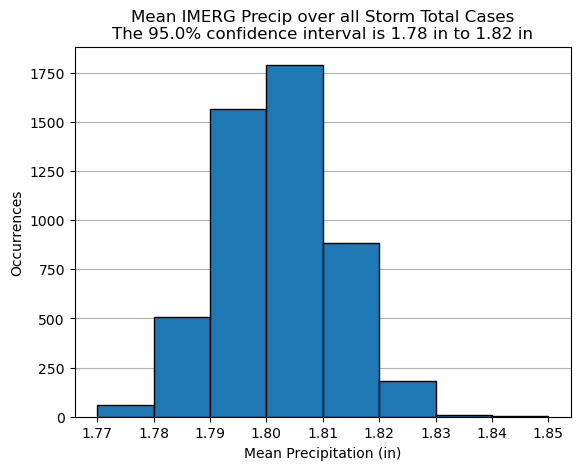

In [164]:
ax1 = plt.axes()
ax1.hist(bootstrap_imerg,density=False,edgecolor='k',bins=np.arange(1.77,1.851,0.01),align='mid')
ax1.set_ylabel('Occurrences')
ax1.set_xlabel('Mean Precipitation (in)')
ax1.grid(axis='y')
ax1.set_axisbelow(True)
all_confidences = []
for ci in [0.6,0.7,0.8,0.9,0.95,0.99]:
    confidences = confidence_intervals(bootstrap_imerg, confidence_level=ci)
    all_confidences.append(confidences)
    lower_conf = all_confidences[0][1]
    upper_conf = all_confidences[0][2]
    curr_conf_level = all_confidences[0][0]
    
ax1.set_title('Mean IMERG Precip over all Storm Total Cases\n' + all_confidences[4][3][0])
    

In [165]:
mrms_flat = pd.DataFrame(mrms_xr.values.ravel())
bootstrap_mrms = bootstrap(mrms_flat, R=5000)

The 60.0% confidence interval is [1.94, 1.96]
The 70.0% confidence interval is [1.93, 1.96]
The 80.0% confidence interval is [1.93, 1.96]
The 90.0% confidence interval is [1.93, 1.97]
The 95.0% confidence interval is [1.92, 1.97]
The 99.0% confidence interval is [1.92, 1.98]


Text(0.5, 1.0, 'Mean MRMS Precip over all Storm Total Cases\nThe 95.0% confidence interval is 1.92 in to 1.97 in')

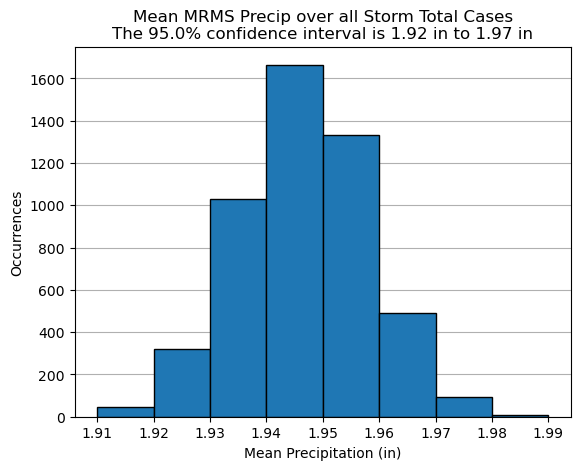

In [166]:
ax2 = plt.axes()
mrms_hist = ax2.hist(bootstrap_mrms,density=False,edgecolor='k',bins=np.arange(1.91,1.99,0.01),align='mid')
ax2.grid(axis='y')
ax2.set_axisbelow(True)
ax2.set_ylabel('Occurrences')
ax2.set_xlabel('Mean Precipitation (in)')
all_confidences = []
for ci in [0.6,0.7,0.8,0.9,0.95,0.99]:
    confidences = confidence_intervals(bootstrap_mrms, confidence_level=ci)
    all_confidences.append(confidences)
    lower_conf = all_confidences[0][1]
    upper_conf = all_confidences[0][2]
    curr_conf_level = all_confidences[0][0]

ax2.set_title('Mean MRMS Precip over all Storm Total Cases\n' + all_confidences[4][3][0])


Text(0.5, 1.0, 'Difference')

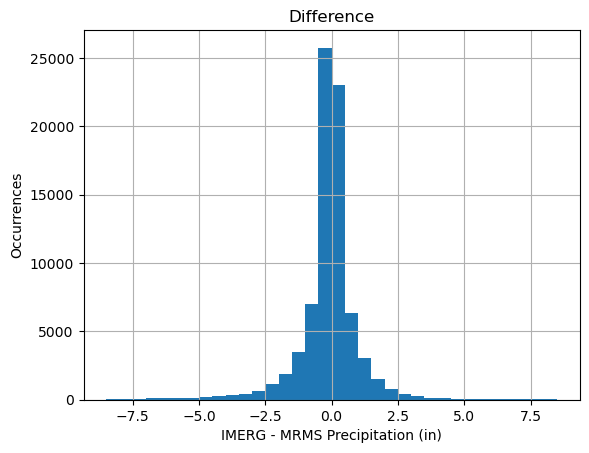

In [71]:
plt.hist(pd.DataFrame(diff_xarray.values.ravel()),bins=np.arange(-8.5,8.6,0.5))
plt.grid()
plt.ylabel('Occurrences')
plt.xlabel('IMERG - MRMS Precipitation (in)')
plt.title('Difference')

Text(0.5, 1.0, 'Mean MRMS Precipitation')

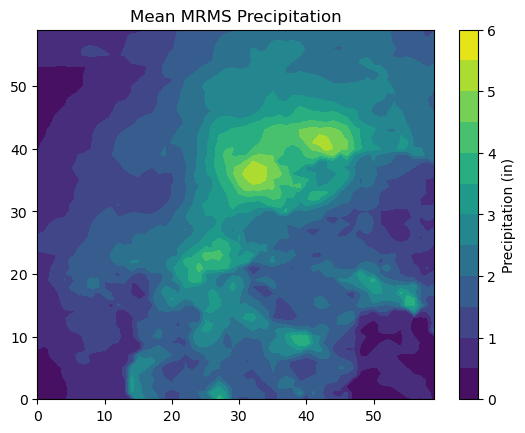

In [72]:
plt.contourf(mrms_xr.mean('dim_0').values,levels=np.arange(0,6.1,0.5))
plt.colorbar(label='Precipitation (in)')
plt.title('Mean MRMS Precipitation')

Text(0.5, 1.0, 'Mean IMERG Precipitation')

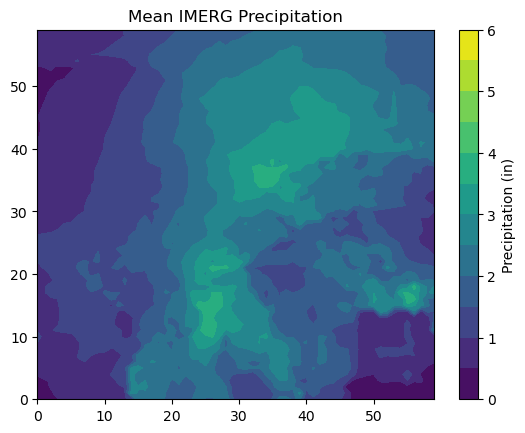

In [73]:
plt.contourf(imerg_xr.mean('dim_0').values,levels=np.arange(0,6.1,0.5))
plt.colorbar(label='Precipitation (in)')
plt.title('Mean IMERG Precipitation')

In [74]:
0.32/imerg_xr.mean(['dim_0','dim_1','dim_2'])

<xarray.DataArray ()> Size: 8B
array(0.17758784)

In [75]:
0.32/mrms_xr.mean(['dim_0','dim_1','dim_2'])

<xarray.DataArray ()> Size: 8B
array(0.16440388)

In [76]:
curr_conf_level

60.0